In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch import optim
import torch.utils as utils
from torchvision import datasets, transforms

In [2]:
print(torch.__version__)

1.4.0+cu92


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x.view(-1))])

dataset_train = datasets.MNIST(
    '~/mnist', 
    train=True, 
    download=True, 
    transform=transform)
dataset_valid = datasets.MNIST(
    '~/mnist', 
    train=False, 
    download=True, 
    transform=transform)

batch_size = 1000

dataloader_train = utils.data.DataLoader(dataset_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=4)
dataloader_valid = utils.data.DataLoader(dataset_valid,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=4)

In [5]:
class VAE(nn.Module):
    def __init__(self, x_dim, z_dim):
      super(VAE, self).__init__()
      self.x_dim = x_dim
      self.z_dim = z_dim
      self.fc1 = nn.Linear(x_dim, 200)
      self.bn1 = nn.BatchNorm1d(200)
      self.fc2_mean = nn.Linear(200, z_dim)
      self.fc2_var = nn.Linear(200, z_dim)

      self.fc3 = nn.Linear(z_dim, 200)
      self.drop1 = nn.Dropout(p=0.2)
      self.fc4 = nn.Linear(200, x_dim)

    def encoder(self, x):
      x = x.view(-1, self.x_dim)
      x = F.relu(self.fc1(x))
      x = self.bn1(x)
      mean = self.fc2_mean(x)
      log_var = self.fc2_var(x)
      return mean, log_var

    def sample_z(self, mean, log_var):
      epsilon = torch.randn(mean.shape, device="cuda")
      return mean + epsilon * torch.exp(0.5*log_var)

    def decoder(self, z):
      y = F.relu(self.fc3(z))
      y = self.drop1(y)
      y = torch.sigmoid(self.fc4(y))
      return y

    def forward(self, x):
      x = x.reshape(-1, self.x_dim)
      mean, log_var = self.encoder(x)
      z = self.sample_z(mean, log_var)
      y = self.decoder(z)
      return z, y

    def loss_sigmoid(self, x):
      x = x.view(-1, self.x_dim)
      mean, log_var = self.encoder(x)
      delta = 1e-8
      KL = 0.5 * torch.sum(1 + log_var - mean**2 - torch.exp(log_var))
      z = self.sample_z(mean, log_var)
      y = self.decoder(z)
      reconstruction = torch.mean(x * torch.log(y + delta) + (1 - x) * torch.log(1 - y + delta))
      lower_bound = [KL, reconstruction]
      return -sum(lower_bound)

In [10]:
model = VAE(x_dim=28*28, z_dim=10).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.train()
for param in model.parameters():
    print(param.shape)

num_epochs = 1
loss_list = []
for i in range(num_epochs):
  losses = []
  for x, t in dataloader_train:
      x = x.to(device)
      model.zero_grad()
      z, y = model(x)
      loss = model.loss_sigmoid(x)/batch_size
      loss.backward()
      optimizer.step()
      losses.append(loss.cpu().detach().numpy())
  loss_list.append(np.average(losses))
  print("EPOCH: {} loss: {}".format(i, np.average(losses)))

torch.Size([200, 784])
torch.Size([200])
torch.Size([200])
torch.Size([200])
torch.Size([10, 200])
torch.Size([10])
torch.Size([10, 200])
torch.Size([10])
torch.Size([200, 10])
torch.Size([200])
torch.Size([784, 200])
torch.Size([784])
EPOCH: 0 loss: 0.21462774276733398


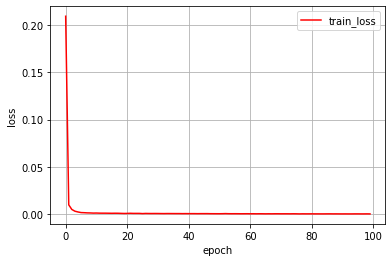

In [16]:
plt.figure()
plt.plot(range(num_epochs), loss_list, 'r-', label='train_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()

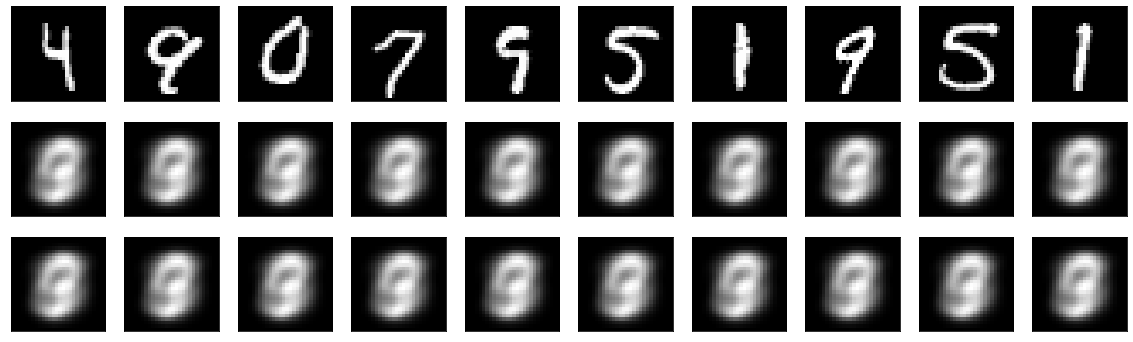

In [17]:
fig = plt.figure(figsize=(20, 6))

model.eval()
zs = []
for x, t in dataloader_valid:
    for i, im in enumerate(x.view(-1, 28, 28).detach().numpy()[:10]):
      ax = fig.add_subplot(3, 10, i+1, xticks=[], yticks=[])
      ax.imshow(im, 'gray')

    x = x.to(device)
    z, y = model(x)
    zs.append(z)
    y = y.view(-1, 28, 28)
    for i, im in enumerate(y.cpu().detach().numpy()[:10]):
      ax = fig.add_subplot(3, 10, i+11, xticks=[], yticks=[])
      ax.imshow(im, 'gray')
    
    z1to0 = torch.cat([z[1, :] * (i * 0.1) + z[0, :] * ((10 - i) * 0.1) for i in range(10)]).reshape(10, 10)
    y2 = model.decoder(z1to0).view(-1, 28, 28)
    for i, im in enumerate(y2.cpu().detach().numpy()[:20]):
      ax = fig.add_subplot(3, 10, i+21, xticks=[], yticks=[])
      ax.imshow(im, 'gray')
    break

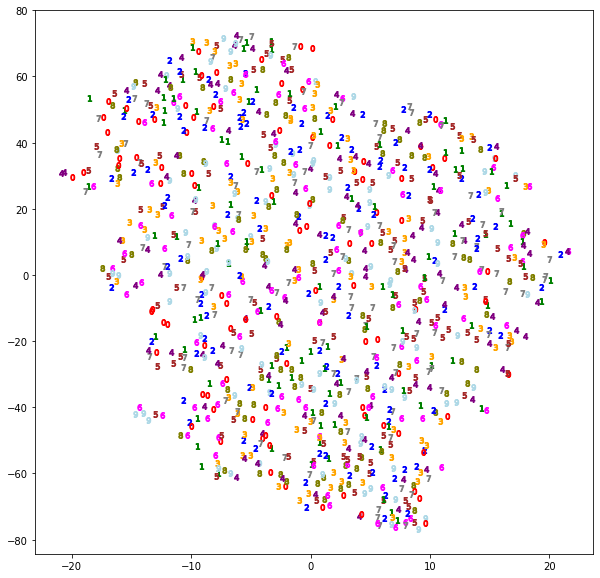

In [9]:
from sklearn.manifold import TSNE
from random import random

colors = ["red", "green", "blue", "orange", "purple", "brown", "fuchsia", "grey", "olive", "lightblue"]
def visualize_zs(zs, labels):
  plt.figure(figsize=(10,10))
  points = TSNE(n_components=2, random_state=0).fit_transform(zs)
  for p, l in zip(points, labels):
    plt.scatter(p[0], p[1], marker="${}$".format(l), c=colors[l])
  plt.show()

model.eval()
zs = []
for x, t in dataloader_valid:
    x = x.to(device)
    t = t.to(device)
    # generate from x
    y, z = model(x)
    z = z.cpu()
    t = t.cpu()
    visualize_zs(z.detach().numpy(), t.cpu().detach().numpy())
    break